In [1]:
# Import necessary modules
import numpy as np
import pytest
import torch
from quafu.algorithms.ansatz import QuantumNeuralNetwork
from quafu.algorithms.gradients import compute_vjp, jacobian
from quafu.algorithms.interface.torch import ModuleWrapper, TorchTransformer
from quafu.algorithms.templates.angle import AngleEmbedding
from quafu.algorithms.templates.basic_entangle import BasicEntangleLayers
from quafu.circuits.quantum_circuit import QuantumCircuit
from quafu.elements import Parameter
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Create a synthetic dataset
def generate_random_dataset(num_inputs, num_samples):
    """
    Generate random dataset

    Args:
        num_inputs: dimension of input data
        num_samples: number of samples in the dataset
    """
    # Generate random input coordinates using PyTorch's rand function
    x = 2 * torch.rand([num_samples, num_inputs], dtype=torch.double) - 1

    # Calculate labels based on the sum of input coordinates
    y01 = (torch.sum(x, dim=1) >= 0).to(torch.long)

    # Convert to one-hot vector
    y = torch.zeros(num_samples, 2)  # Two classes (0 and 1)
    y[torch.arange(num_samples), y01] = 1

    # Create a PyTorch dataset
    dataset = TensorDataset(x, y)

    return dataset

dataset = generate_random_dataset(2, 100)

x = dataset.tensors[0]

Text(0.5, 1.0, 'Random Dataset')

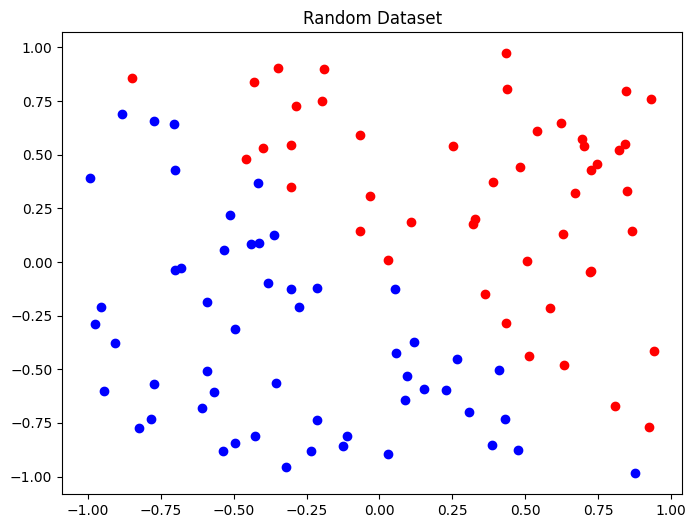

In [3]:
# Virtualize the data
import matplotlib.pyplot as plt

# Extract x and y from dataset
x = dataset.tensors[0]
y = dataset.tensors[1]

# Plotting the data points with different colors based on labels
plt.figure(figsize=(8, 6))

# Extract coordinates for each class
x_class0 = x[y[:, 0] == 1]
x_class1 = x[y[:, 1] == 1]

# Plot points for each class with different colors
plt.scatter(x_class0[:, 0], x_class0[:, 1], color='blue', label='Class 0')
plt.scatter(x_class1[:, 0], x_class1[:, 1], color='red', label='Class 1')

plt.title('Random Dataset')

In [4]:
# Create a quantum classifier using pyquafu
num_qubits = 2
weights = np.random.randn(num_qubits, num_qubits)
encoder_layer = AngleEmbedding(np.random.random((num_qubits,)), num_qubits=2)
entangle_layer = BasicEntangleLayers(weights, num_qubits=num_qubits)
qnn = QuantumNeuralNetwork(num_qubits, encoder_layer + entangle_layer)

# Convert to torch module
model = ModuleWrapper(qnn)

Alternatively, you could also customize encoder layer and ansatz layer

In [ ]:
# Create a quantum classifier using pyquafu
import quafu.elements.element_gates as qeg
num_qubits = 2
weights = np.random.randn(num_qubits, num_qubits)
data = []
inputs0 = np.random.random((num_qubits * 2,))

# customize encoder layer
ry0 = qeg.RYGate(0, Parameter("theta_0", inputs0[0], tunable=False))
ry1 = qeg.RYGate(0, Parameter("theta_1", inputs0[1], tunable=False))
x = qeg.XGate(1)
cnot = qeg.CXGate(0, 1)
rx0 = qeg.RYGate(0, Parameter("theta_3", inputs0[3], tunable=False))
rx1 = qeg.RYGate(0, Parameter("theta_4", inputs0[4], tunable=False))
encoder_layer = [ry0, ry1, x, cnot, rx0, rx1]

entangle_layer = BasicEntangleLayers(weights, num_qubits=num_qubits)
qnn1 = QuantumNeuralNetwork(num_qubits, encoder_layer + entangle_layer)

# Convert to torch module
model1 = ModuleWrapper(qnn1)

In [5]:
# Virtualize the circuit
qnn.draw_circuit()

q[0]  --RX(0.870)----RX(0.310)-----*----RX(2.138)----*--
                                   |                 |  
q[1]  --RX(0.740)----RX(-1.888)----+----RX(0.043)----+--


In [6]:
learning_rate = 0.1
batch_size = 8
num_epochs = 5

# Train the classifier
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create data loader
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train the model
for epoch in range(num_epochs):
    for inputs, labels in data_loader:
        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update the parameters
        optimizer.step()

        print(f" ----- Loss: {loss.item()}")

    # Print the loss
    print(f"Epoch {epoch + 1}/{num_epochs}: Loss = {loss.item()}")

# Evaluate the model on the dataset
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in data_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.argmax(dim=1)).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")

 ----- Loss: 0.9615325233574474
 ----- Loss: 0.9194733350912121
 ----- Loss: 0.8931470706539846
 ----- Loss: 1.0503941422362684
 ----- Loss: 0.9908540916120671
 ----- Loss: 0.831051357243214
 ----- Loss: 0.8619902350795049
 ----- Loss: 0.7945578709369877
 ----- Loss: 0.7733395084352032
 ----- Loss: 0.7370698765793892
 ----- Loss: 0.7087369934765426
 ----- Loss: 0.6990222640637548
 ----- Loss: 0.6729794460770855
Epoch 1/5: Loss = 0.6729794460770855
 ----- Loss: 0.6895816165378665
 ----- Loss: 0.6861536674558707
 ----- Loss: 0.683243568754467
 ----- Loss: 0.6916647736681723
 ----- Loss: 0.6903605056577911
 ----- Loss: 0.6910721320884553
 ----- Loss: 0.6871586681137746
 ----- Loss: 0.6805190094955192
 ----- Loss: 0.6770529229934533
 ----- Loss: 0.6517807017674097
 ----- Loss: 0.6445985476671462
 ----- Loss: 0.6184428838887601
 ----- Loss: 0.6631814472495701
Epoch 2/5: Loss = 0.6631814472495701
 ----- Loss: 0.6086276839146854
 ----- Loss: 0.5327462219405604
 ----- Loss: 0.5929885820417882
